A data consulting company has a new client that is a popular chain of malls spread across many countries. The mall wishes to gain a better understanding of its customers to re-design their existing offerings and marketing communications to improve sales in a geographical area. The data about the customers is available in the Mall_Customers.csv file.

## Understanding the Data

In [ ]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data0 = pd.read_csv("/content/drive/MyDrive/Marketing-Analytics/Data/Mall_Customers.csv")
data0.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


We see that we have information such as the gender and age of the customers, along with their estimated annual income (Annual Income (k$)). We also have a spending score calculated by the mall (Spending Score (1-100)), which denotes the amount of shopping the customer has done at the mall – a higher score means a higher spend.

In [ ]:
data0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


#### Renaming columns

In [ ]:
data0.rename({'Annual Income (k$)':'Income', \
              'Spending Score (1-100)':'Spend_score'}, axis=1, \
             inplace=True)
data0.head()

,CustomerID,Gender,Age,Income,Spend_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
data0.describe()

,CustomerID,Age,Income,Spend_score
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


Overall averages show that the average age of the customer is around 39 and the average income is around 61,000 USD. The spend scores seem to be calculated based on percentiles – having a minimum value of 1 and a maximum of 99. 

## Segmentation of Mall Customers

The mall wants to segment its customers and plans to use the derived segments to improve its marketing campaigns. The business team has a belief that segmenting based on income levels is relevant for their offerings.

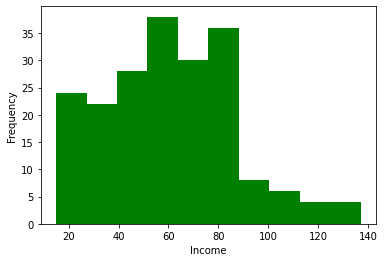

In [ ]:
data0.Income.plot.hist(color='green')
plt.xlabel('Income')
plt.show()

Beyond 90k, the frequency in the bins falls sharply and it seems that these customers can naturally be considered a separate group representing high-income customers. A good proportion of customers seems to lie in the 50k-90k range. These can be considered moderate-income customers. Customers earning less than 40k would be low-income customers. We can use these cutoffs to divide the customers into three groups. 

The following code creates a new column ‘Cluster’ to have the values ‘Low Income’, ‘Moderate Income’, ‘High earners’ for customers with income in the ranges < 50, 50 – 90, and >= 90 respectively.

In [ ]:
data0['Cluster'] = np.where(data0.Income >= 90, 'High earners', np.where(data0.Income < 50, 'Low Income', 'Moderate Income'))

In [ ]:
data0.groupby('Cluster')['Income'].describe()

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
High earners,22.0,108.181818,13.661334,93.0,98.25,103.0,118.25,137.0
Low Income,72.0,33.027778,11.091136,15.0,22.50,33.5,43.00,49.0
Moderate Income,106.0,69.377358,10.651584,50.0,61.00,70.0,78.00,88.0


Standardizing Customer Data

Standardizing is done with the following steps:
 1. First, subtract the mean of the data from each data point. This centers the data around 0, to make the data easier to look at and interpret. 
 2. The second step is to divide the parameters by their standard deviation.

$ Z_i = \frac{x_i - mean(x)}{std(x)} $

By dividing all the values of Age by the standard deviation of the ages, we transform the data such that the standard deviation is equal to 1. When we do the same thing with the income, the standard deviation of the income will also be equal to 1. Therefore, a difference of 1 between two customers on either of these measures would indicate a similar level of difference between them. This ensures that all features have a similar influence on the formation of the clusters.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
cols_to_scale = ['Age', 'Income', 'Spend_score']

In [ ]:
data_scaled = data0.copy()

In [ ]:
# calculate the mean and the standard deviation for each of the columns

data_scaled[cols_to_scale] = scaler.fit_transform(data0[cols_to_scale])

In [ ]:
data_scaled[cols_to_scale].describe()

,Age,Income,Spend_score
count,2.000000e+02,2.000000e+02,2.000000e+02
mean,-9.603429e-17,-6.128431e-16,-1.121325e-16
std,1.002509e+00,1.002509e+00,1.002509e+00
min,-1.496335e+00,-1.738999e+00,-1.910021e+00
25%,-7.248436e-01,-7.275093e-01,-5.997931e-01
50%,-2.045351e-01,3.587926e-02,-7.764312e-03
75%,7.284319e-01,6.656748e-01,8.851316e-01
max,2.235532e+00,2.917671e+00,1.894492e+00


### Calculating distance between customers

The geometric distance between entities in feature space is a natural way of measuring dissimilarity. On a two-dimensional scatter plot, the Euclidean distance between two customers (p and q) is just the distance between their points calculated as follows: $ d(p, q) = \sqrt{\sum (p_i - q_i)^2} $

In [ ]:
sel_cols = ['Income', 'Spend_score']
cust3 = data_scaled[sel_cols].head(3)
cust3

,Income,Spend_score
0,-1.738999,-0.434801
1,-1.738999,1.195704
2,-1.700830,-1.715913


In [ ]:
from scipy.spatial.distance import cdist

In [ ]:
cdist(cust3, cust3, metric='euclidean')

array([[0.        , 1.63050555, 1.28167999],
       [1.63050555, 0.        , 2.91186723],
       [1.28167999, 2.91186723, 0.        ]])

The output shows that the distance between the first and the second customer is 1.63 units, while the distance between the first and the third customer is 1.28 units. The distance between the second and the third customer is 2.92 units.

## k-means Clustering on Mall Customers

K-means clustering is an algorithm that tries to find the best way of grouping data points into k different groups, where k is a parameter given to the algorithm.

The algorithm works iteratively to try to find the best grouping. There are two steps to this algorithm:
 1. The algorithm begins by randomly selecting k points in space to be the centroids of the clusters. Each data point is then assigned to the centroid that is closest to it.
 2. The centroids are updated to be the mean of all of the data points assigned to them. The data points are then reassigned to the centroid closest to them. This step is repeated until none of the data points change the centroid they are assigned to after the centroid is updated.



In [ ]:
cluster_cols = ['Income', 'Spend_score']
data_scaled[cluster_cols].head(3)

,Income,Spend_score
0,-1.738999,-0.434801
1,-1.738999,1.195704
2,-1.700830,-1.715913


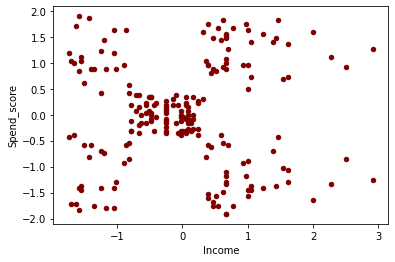

In [ ]:
data_scaled.plot.scatter(x='Income', y='Spend_score', \
                         color='maroon')
plt.show()

From the plot, there are 5 natural clusters in the data. This hints to specify 5 as the number of clusters for the k-means algorithm.

In [ ]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=5, random_state=42)

In [ ]:
model.fit(data_scaled[cluster_cols])

data_scaled['Cluster'] = model.predict(data_scaled[cluster_cols])

In [ ]:
data_scaled.head(3)

,CustomerID,Gender,Age,Income,Spend_score,Cluster
0,1,Male,-1.424569,-1.738999,-0.434801,2
1,2,Male,-1.281035,-1.738999,1.195704,3
2,3,Female,-1.352802,-1.700830,-1.715913,2


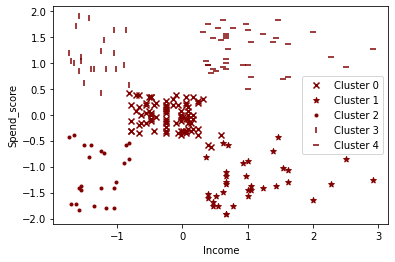

In [ ]:
markers = ['x', '*', '.','|','_']

for clust in range(5):
    temp = data_scaled[data_scaled.Cluster == clust]
    plt.scatter(temp.Income, temp.Spend_score, \
                marker=markers[clust], \
                color = 'maroon',\
                label="Cluster "+str(clust))
plt.xlabel('Income')
plt.ylabel('Spend_score')
plt.legend()
plt.show()

To understand the characteristics of the clusters better, the following plot will analyze the features in the original scale:

 * Cluster 0: Moderate-income moderate spenders  
 * Cluster 1: High-income low spenders
 * Cluster 2: Low-income low spenders 
 * Cluster 3: Low-income high spenders
 * Cluster 4: High-income high spenders

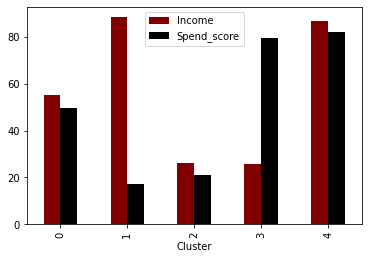

In [ ]:
data0['Cluster'] = data_scaled.Cluster

data0.groupby('Cluster')[['Income', 'Spend_score']].mean().plot.bar(color=['maroon','black'])

plt.show()

### This section adds Age to the kmeans cluster analysis

In [ ]:
cluster_cols = ['Age', 'Income', 'Spend_score']
data_scaled[cluster_cols].head(3)

,Age,Income,Spend_score
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913


In [ ]:
model = KMeans(n_clusters=4, random_state=42)
model.fit(data_scaled[cluster_cols])

KMeans(n_clusters=4, random_state=42)

In [ ]:
data_scaled['Cluster'] = model.predict(data_scaled[cluster_cols])

Principle component analysis (PCA) is a dimensionality reduction technique in which components are calculated in place of original values; PCA summarizes or combines correlated features together to decrease the overall number of features.

 * principal component equation: $ \text{maximize } \frac{1}{n} \sum^n_{i=1} (\sum^p_{j=1} \phi_jx_{ij})^2 $ 

In [ ]:
from sklearn import decomposition

# use pca to reduce the dimmensions of the data to 2
pca = decomposition.PCA(n_components=2)
pca_res = pca.fit_transform(data_scaled[cluster_cols])

data_scaled['pc1'] = pca_res[:,0]
data_scaled['pc2'] = pca_res[:,1]

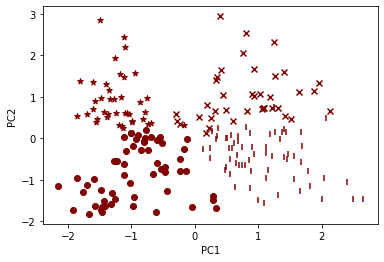

In [ ]:
markers = ['x', '*', 'o','|']

for clust in range(4):
    temp = data_scaled[data_scaled.Cluster == clust]
    plt.scatter(temp.pc1, temp.pc2, marker=markers[clust], \
                label="Cluster "+str(clust), \
                color='maroon')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [ ]:
data0['Cluster'] = data_scaled.Cluster

In [ ]:
data0.groupby('Cluster')[['Age', 'Income', 'Spend_score']].mean()

,Age,Income,Spend_score
Cluster,,,
0,39.368421,86.500000,19.578947
1,32.875000,86.100000,81.525000
2,25.438596,40.000000,60.298246
3,53.984615,47.707692,39.969231


To understand the characteristics of the clusters better, the following plot will analyze the features in the original scale:

 * Cluster 0: Middle-aged penny pinchers (high income, low spend)

 * Cluster 1: Young high rollers (younger age, high income, high spend)

 * Cluster 2: Young aspirers (low income, high spend)

 * Cluster 3: Old average Joes (average income, average spend)

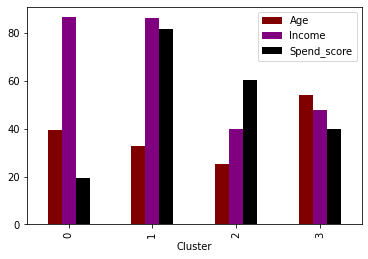

In [ ]:
data0.groupby('Cluster')[['Age', 'Income', 'Spend_score']].mean() \
     .plot.bar(color=['maroon', 'purple', 'black'])
plt.show()

# Mall Customers - Case 2

Now the mall wishes to re-design its existing offers and marketing communications to improve sales in one of its key markets. This section looks at additional ways to use K-means clustering. 

In [ ]:
mall0 = data0.copy()
mall0.head()

,CustomerID,Gender,Age,Income,Spend_score,Cluster
0,1,Male,19,15,39,2
1,2,Male,21,15,81,2
2,3,Female,20,16,6,2
3,4,Female,23,16,77,2
4,5,Female,31,17,40,2


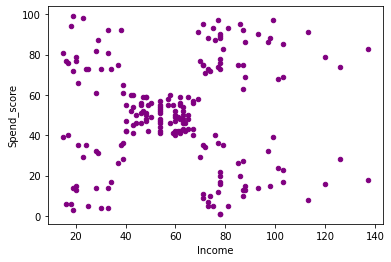

In [ ]:
mall0.plot.scatter(x='Income', y='Spend_score', color='purple')
plt.show()

### Choosing the Number of Clusters Based on Visual Inspection

Choosing the optimal number of clusters by refining the customer segmentation approach by using visual inspection (ranging from two to seven clusters).

In [ ]:
mall_scaled = mall0.copy()
cols_to_scale = ['Age', 'Income', 'Spend_score']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

mall_scaled[cols_to_scale] = scaler.fit_transform(mall_scaled[cols_to_scale])

In [ ]:
from sklearn.cluster import KMeans

cluster_cols = ['Income', 'Spend_score']

markers = ['x', '*', '.', '|', '_', '1', '2']

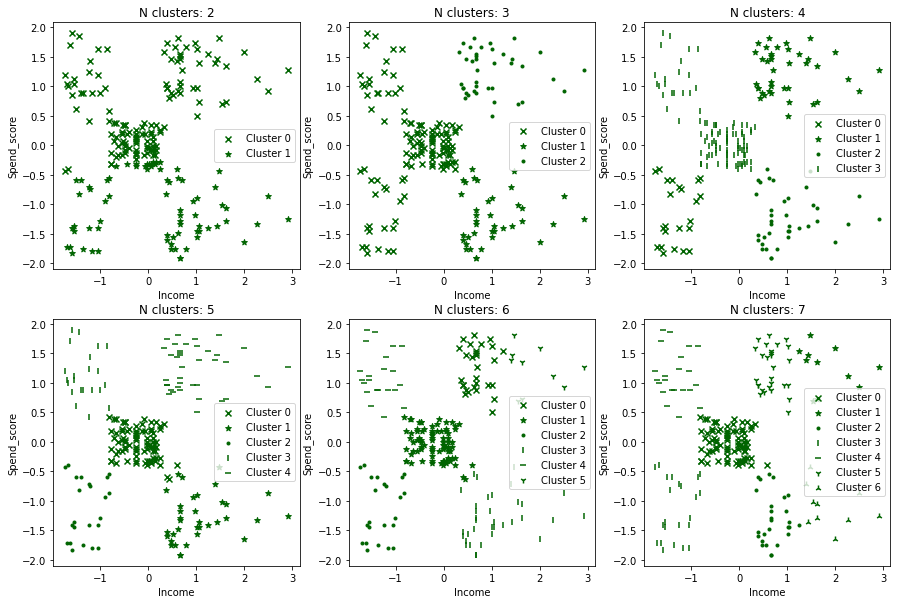

In [ ]:
plt.figure(figsize=[15,10])
for n in range(2,8):
    model = KMeans(n_clusters=n, random_state=42)
    mall_scaled['Cluster']= model.fit_predict(mall_scaled[cluster_cols])

    plt.subplot(2,3, n-1)
    for clust in range(n):
        temp = mall_scaled[mall_scaled.Cluster == clust]
        plt.scatter(temp.Income, temp.Spend_score, marker=markers[clust], label="Cluster "+str(clust), color='darkgreen')
        plt.title("N clusters: "+str(n))
        plt.xlabel('Income')
        plt.ylabel('Spend_score')
        plt.legend()

plt.show()

The optimal number of clusters from this analysis is five. 

### Choosing the Number of Clusters with the Elbow Method

 *  Inertia Plot - an elbow in a plot of the sum of squared errors
 * Sum of Squared Errors (SSE) - the sum of the "errors" (the difference between a data point and the centroid of its assigned cluster) for all data points, squared. The tighter the clusters, the closer the constituent points to their respective clusters, and the lower the SSE/inertia.

SSE $= \sum_k \sum_{x_i\in k}(x_i - \mu_k)^2 $
 * SSE - sum of squared errors
 * μ_k is the location of the centroid of cluster $k$
 * $x_i$ is a data point assigned to cluster $k$

In [ ]:
X = mall_scaled[cluster_cols]

In [ ]:
inertia_scores = []
for K in range(2,11):
    inertia = KMeans(n_clusters=K, random_state=42).fit(X).inertia_
    inertia_scores.append(inertia)

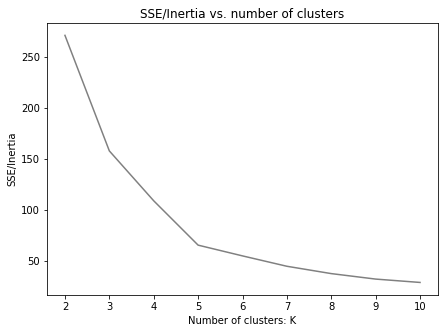

In [ ]:
plt.figure(figsize=[7,5])
plt.plot(range(2,11), inertia_scores, color='gray')
plt.title("SSE/Inertia vs. number of clusters")
plt.xlabel("Number of clusters: K")
plt.ylabel('SSE/Inertia')
plt.show()

There is an elbow in the plot at K=5, therefore, take five as the optimal number of clusters, the best value of K for the KMeans algorithm.